In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import utils
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DIR_PATH = "Data"
DIRPATH_EXTRACTED_FEATURES = "extracted_features"

In [2]:
class CustomDataset(Dataset):
    def __init__(self, brands: list, filenames_features: list, filename_target=utils.FILENAME_RELEVANCE_WINDOW, log_target=False, device=device, filter_uniform_features=False):
        self.log_target = log_target
        self.device = device
        self.features = torch.concat([torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_feature), map_location=device) 
                         for filename_feature in filenames_features], dim=1)
                            for brand in brands], dim=0)
        self.target = torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_target), map_location=device) 
                            for brand in brands], dim=0)
        if log_target:
            self.target = torch.log(self.target)
        self.filter_uniform_features = filter_uniform_features
        if self.filter_uniform_features:
            self.features = self.features[:,(self.features != self.features[0]).any(0)]

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]
    

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn=nn.ReLU(), batchnorm=False):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential()
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(input_size, hidden_size))
            if batchnorm:
                self.layers.append(nn.BatchNorm1d(hidden_size))
            self.layers.append(activation_fn)
            input_size = hidden_size
        self.layers.append(nn.Linear(input_size, output_size))
    
    def forward(self, x):
        out = self.layers(x)
        return out
    

class TargetWeightedLoss(nn.Module):
    def __init__(self, target_bincount):
        super(TargetWeightedLoss, self).__init__()
        self.target_bincount = 1 / (target_bincount.float() + 1)
    
    def forward(self, output, target):
        loss = torch.mean((torch.abs(output - target)**2 * self.target_bincount[target.int()]))
        return loss    
    

class LNLoss(nn.Module):
    def __init__(self, N):
        super(LNLoss, self).__init__()
        self.N = N
    
    def forward(self, output, target):
        loss = torch.mean(torch.abs(output - target)**self.N)
        return loss

In [4]:
filenames_features = [
    utils.FILENAME_BRAND_OHE,
    utils.FILENAME_PUBLICATION_TIMESTAMP,
    utils.FILENAME_PUBLICATION_WEEKDAY_OHE,
    utils.FILENAME_NUM_WORDS,
    utils.FILENAME_NUM_PARAGRAPH,
    # utils.FILENAME_MAIN_SECTION_OHE,
    # utils.FILENAME_SUBSECTIONS_OHE,
    utils.FILENAME_LDA_TOPICS,
    utils.FILENAME_IPTC_TOPICS_LEVEL_0,
    utils.FILENAME_IPTC_TOPICS_LEVEL_1,
]

brands = utils.ALL_BRANDS


dataset = CustomDataset(brands, filenames_features, filter_uniform_features=False, log_target=True)
dataset.features.shape

/tmp/ipykernel_119080/1406405855.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.features = torch.concat([torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FE

torch.Size([213466, 168])

In [5]:
batch_size = 1024 
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
EPOCHS = 30
train_loss = []
test_loss = []
model = SimpleMLP(input_size=dataset.features.shape[1], hidden_sizes=[128,128], output_size=1, batchnorm=True)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

eval_per_n_batches = 10


loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
# loss_fn = TargetWeightedLoss(torch.bincount(dataset.target.int().squeeze()).to(device))
# loss_fn = LNLoss(3)


for epoch in range(EPOCHS):

    model.train(True)
    
    running_loss = 0.

    for i, data in enumerate(train_dataloader):
        model.train(True)
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % eval_per_n_batches == (eval_per_n_batches-1):
            avg_loss = running_loss / eval_per_n_batches 
            train_loss.append(avg_loss)

            running_loss = 0.

            running_vloss = 0.0

            model.eval()
            with torch.no_grad():
                for i, vdata in enumerate(test_dataloader):
                    vinputs, vlabels = vdata
                    voutputs = model(vinputs)
                    vloss = loss_fn(voutputs, vlabels)
                    running_vloss += vloss 

            avg_vloss = running_vloss / len(test_dataloader)
            test_loss.append(avg_vloss.item())
    print(f"finished epoch {epoch+1}/{EPOCHS} with eval loss {test_loss[-1]:.3f}")

finished epoch 1/30 with eval loss 10.647
finished epoch 2/30 with eval loss 9.512
finished epoch 3/30 with eval loss 8.766
finished epoch 4/30 with eval loss 8.027
finished epoch 5/30 with eval loss 7.444
finished epoch 6/30 with eval loss 6.823
finished epoch 7/30 with eval loss 6.339
finished epoch 8/30 with eval loss 5.851
finished epoch 9/30 with eval loss 5.327
finished epoch 10/30 with eval loss 4.962
finished epoch 11/30 with eval loss 4.588
finished epoch 12/30 with eval loss 4.229
finished epoch 13/30 with eval loss 3.892
finished epoch 14/30 with eval loss 3.586
finished epoch 15/30 with eval loss 3.264
finished epoch 16/30 with eval loss 2.962
finished epoch 17/30 with eval loss 2.672
finished epoch 18/30 with eval loss 2.442
finished epoch 19/30 with eval loss 2.193
finished epoch 20/30 with eval loss 1.996
finished epoch 21/30 with eval loss 1.887
finished epoch 22/30 with eval loss 1.651
finished epoch 23/30 with eval loss 1.533
finished epoch 24/30 with eval loss 1.337


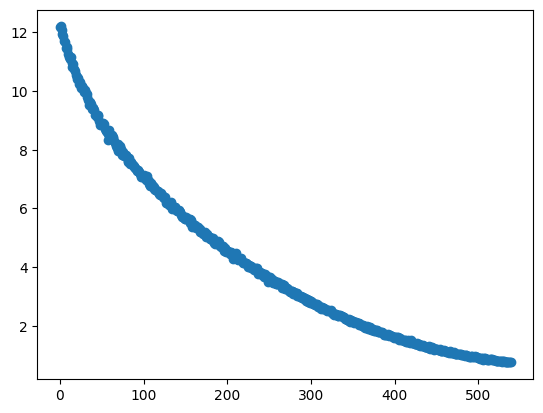

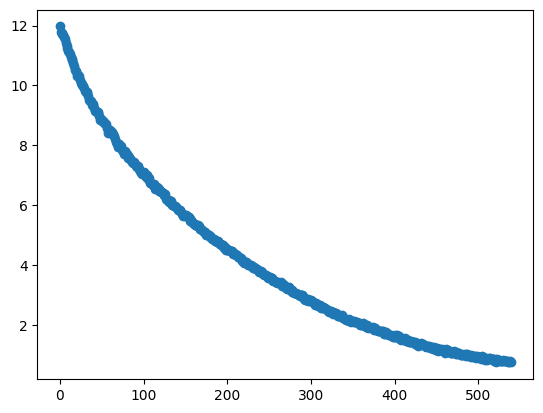

In [7]:
plt.scatter(range(len(train_loss)), train_loss)
plt.show()
plt.scatter(range(len(test_loss)), test_loss)
plt.show()

In [8]:
with torch.no_grad():
    model.eval()
    y_train = dataset[train_dataset.indices][1].cpu()
    y_pred_train = model(dataset[train_dataset.indices][0]).cpu()
    abs_dif_train = torch.abs(y_pred_train - y_train)

    y_test = dataset[test_dataset.indices][1].cpu()
    y_pred_test = model(dataset[test_dataset.indices][0]).cpu()
    abs_dif_test = torch.abs(y_pred_test - y_test)


E1

tensor(0.4604) tensor(0.4210)

tensor(0.4623) tensor(0.4248)


S1 or E2

tensor(0.4504) tensor(0.4063)

tensor(0.4497) tensor(0.4049)


No time

tensor(0.6854) tensor(0.5782)
tensor(0.6815) tensor(0.5787)


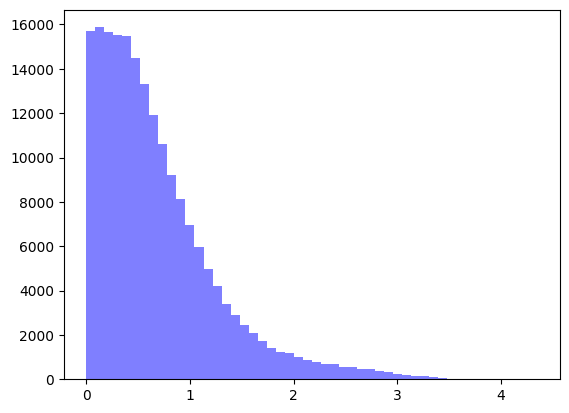

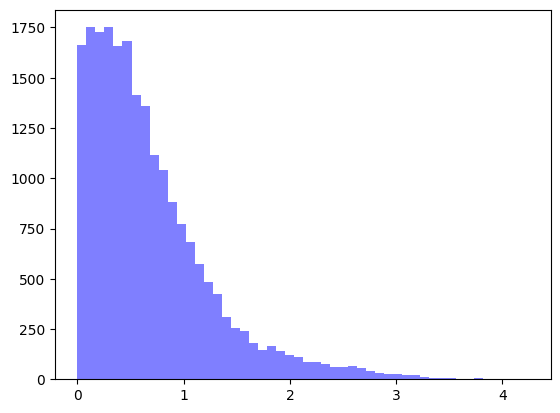

In [9]:
print(abs_dif_train.mean(), abs_dif_train.std())
print(abs_dif_test.mean(), abs_dif_test.std())
plt.hist(abs_dif_train, bins=50, alpha=0.5, color='b')
plt.show()
plt.hist(abs_dif_test, bins=50, alpha=0.5, color='b')
plt.show()

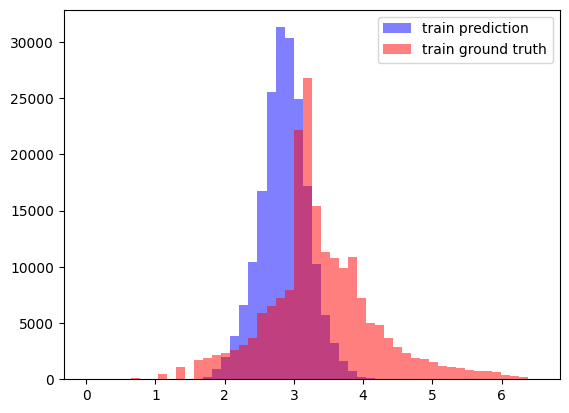

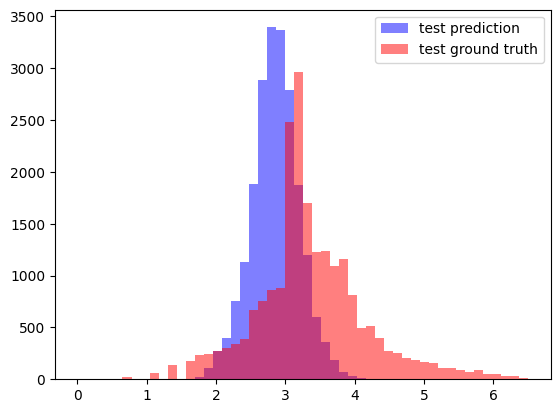

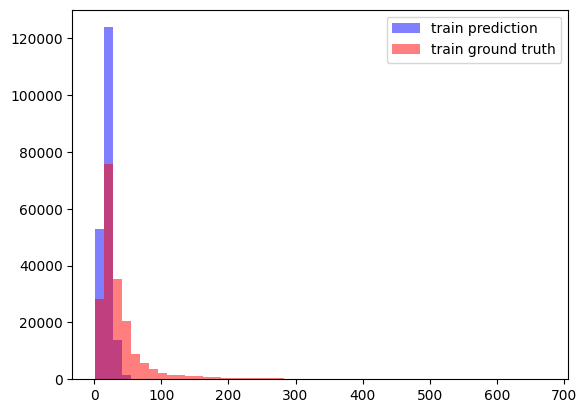

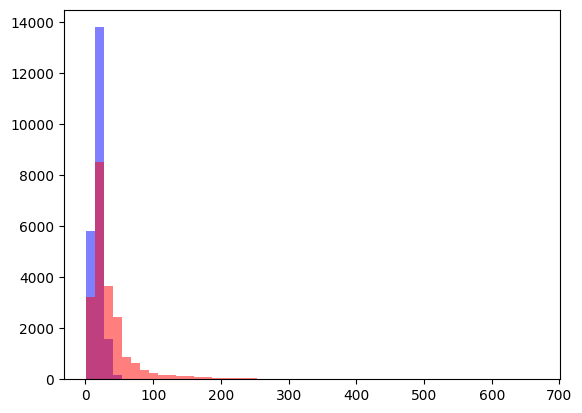

In [10]:
n_bins = 50
bins = np.histogram(np.hstack((y_pred_train,y_train)), bins=n_bins)[1]
plt.hist(y_pred_train, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test,y_test)), bins=n_bins)[1]
plt.hist(y_pred_test, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.show()

if dataset.log_target:
    y_pred_train_trans = torch.exp(y_pred_train)
    y_train_trans = torch.exp(y_train)
    y_pred_test_trans = torch.exp(y_pred_test)
    y_test_trans = torch.exp(y_test)
else:
    y_pred_train_trans = torch.log(y_pred_train)
    y_train_trans = torch.log(y_train)
    y_pred_test_trans = torch.log(y_pred_test)
    y_test_trans = torch.log(y_test)

bins = np.histogram(np.hstack((y_pred_train_trans,y_train_trans)), bins=n_bins)[1]
plt.hist(y_pred_train_trans, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train_trans, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test_trans,y_test_trans)), bins=n_bins)[1]
plt.hist(y_pred_test_trans, bins=bins, alpha=0.5, color='b')
plt.hist(y_test_trans, bins=bins, alpha=0.5, color='r')
plt.show()